In [1]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../')
from my_utils.custom_linear_regression import CustomLinearRegression

sns.set_theme(
    style="whitegrid",   # options: white, dark, whitegrid, darkgrid, ticks
    context="talk",      # scaling: paper, notebook, talk, poster
    palette="deep"       # color palettes: deep, muted, bright, dark, colorblind
)

/home/mustafa/miniconda3/envs/t2/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:

data = load_diabetes(as_frame=True)

features = data.data
target = data.target

X_train, X_test, y_train, y_test  = train_test_split(features, target, test_size=0.3, random_state=42, shuffle=True)

scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [3]:
from sklearn.model_selection import KFold

def kfold( X, y, model_class, n_splits=5, **model_kwargs):
    """
        Perform K-Fold cross-validation on a given model and dataset.

        Parameters
        ----------
        X : pd.DataFrame or np.ndarray
            Feature matrix of shape (n_samples, n_features).

        y : pd.Series or np.ndarray
            Target vector of shape (n_samples,).

        model_class : class
            A class implementing a `fit` and `predict` method (e.g., CustomLinearRegression, SVR).

        n_splits : int, default=5
            Number of folds for cross-validation.

        **model_kwargs : dict
            Additional keyword arguments to initialize the model.

        Returns
        -------
        mean_mse_score : float
            The average mean squared error across all folds.

        mean_r2_score : float
            The average R² score across all folds.

        mse_change_percent : float
            Percentage improvement in mean squared error compared to predicting the mean of `y`.

        r2_scores : list of float
            List of R² scores for each fold.

        mse_scores : list of float
            List of MSE values for each fold.

        Notes
        -----
        - Uses scikit-learn's `KFold` for splitting the data.
        - Computes baseline MSE using the variance of `y`.
        - Useful for model evaluation and hyperparameter tuning.

        Examples
        --------
        >>> lr_params = {'learning_rate': 0.01, 'regularize': True, 'regularization_strength': 0.1}
        >>> mean_mse, mean_r2, mse_change, r2s, mses = kfold(X, y, CustomLinearRegression, n_splits=5, **lr_params)

        >>> svr_params = {'kernel':'linear', 'C':1}
        >>> mean_mse, mean_r2, mse_change, r2s, mses = kfold(X, y, SVR, n_splits=5, **svr_params)
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_scores = []
    r2_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = ( X.iloc[train_index], X.iloc[val_index] ) if isinstance(X, pd.DataFrame) else ( X[train_index], X[val_index] )
        y_train, y_val = ( y.iloc[train_index], y.iloc[val_index] ) if isinstance(y, pd.Series) else ( y[train_index], y[val_index] )

        model = model_class(**model_kwargs).fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)

        r2 = r2_score(y_val, y_pred)
        r2_scores.append(r2)

    mean_mse_score = np.mean(mse_scores)
    baseline_mse = np.mean((y - y.mean())**2)  # or just variance of y
    mse_change_percent  = np.round( (baseline_mse - mean_mse_score) / baseline_mse * 100,  0)

    mean_r2_score = np.mean(r2_scores)

    print(f"\nOn average, across all folds, the variance in the validation data that the model explains is: {mean_r2_score * 100:.2f}%")
    print(f"Compared to naively just predicting the mean, the model's mean squared error changed by: {mse_change_percent:.0f}%.\n")

    return mean_mse_score, mean_r2_score, mse_change_percent, r2_scores, mse_scores

In [4]:
n_splits = 5

lr_custom_params = {'learning_rate': 0.01, 'regularize': True, 'regularization_strength': 1, 'verbose': False}
mean_mse_score, mean_r2_score, mse_change_percent, r2_scores, mse_scores = kfold(X_train, y_train, n_splits=n_splits,
                                                                                 **lr_custom_params,
                                                                                 model_class=CustomLinearRegression)

param = {'alpha': 0.01}
mean_mse_score_ridge, mean_r2_score_ridge, mse_change_percent_ridge, r2_scores_ridge, mse_scores_ridge = kfold(X_train, y_train, n_splits=n_splits, **param,
                                                                             model_class=Ridge)

Early stopping at iteration: 801 due to ΔCost being less 0.001

On average, across all folds, the variance in the validation data that the model explains is: 47.17%
Compared to naively just predicting the mean, the model's mean squared error changed by: 48%.


On average, across all folds, the variance in the validation data that the model explains is: 46.88%
Compared to naively just predicting the mean, the model's mean squared error changed by: 47%.



In [5]:
pd.DataFrame({'MSE scores (Linear Regression)': mse_scores, 'MSE scores (Ridge)': mse_scores_ridge,
              'R2 scores (Linear Regression)': r2_scores, 'R2 scores (Ridge)': r2_scores_ridge,
              }).round(3)

,MSE scores (Linear Regression),MSE scores (Ridge),R2 scores (Linear Regression),R2 scores (Ridge)
0,3113.114,3121.347,0.515,0.514
1,2666.610,2595.289,0.476,0.490
2,3349.528,3654.514,0.515,0.471
3,3373.181,3324.144,0.423,0.431
4,3503.465,3451.259,0.430,0.438


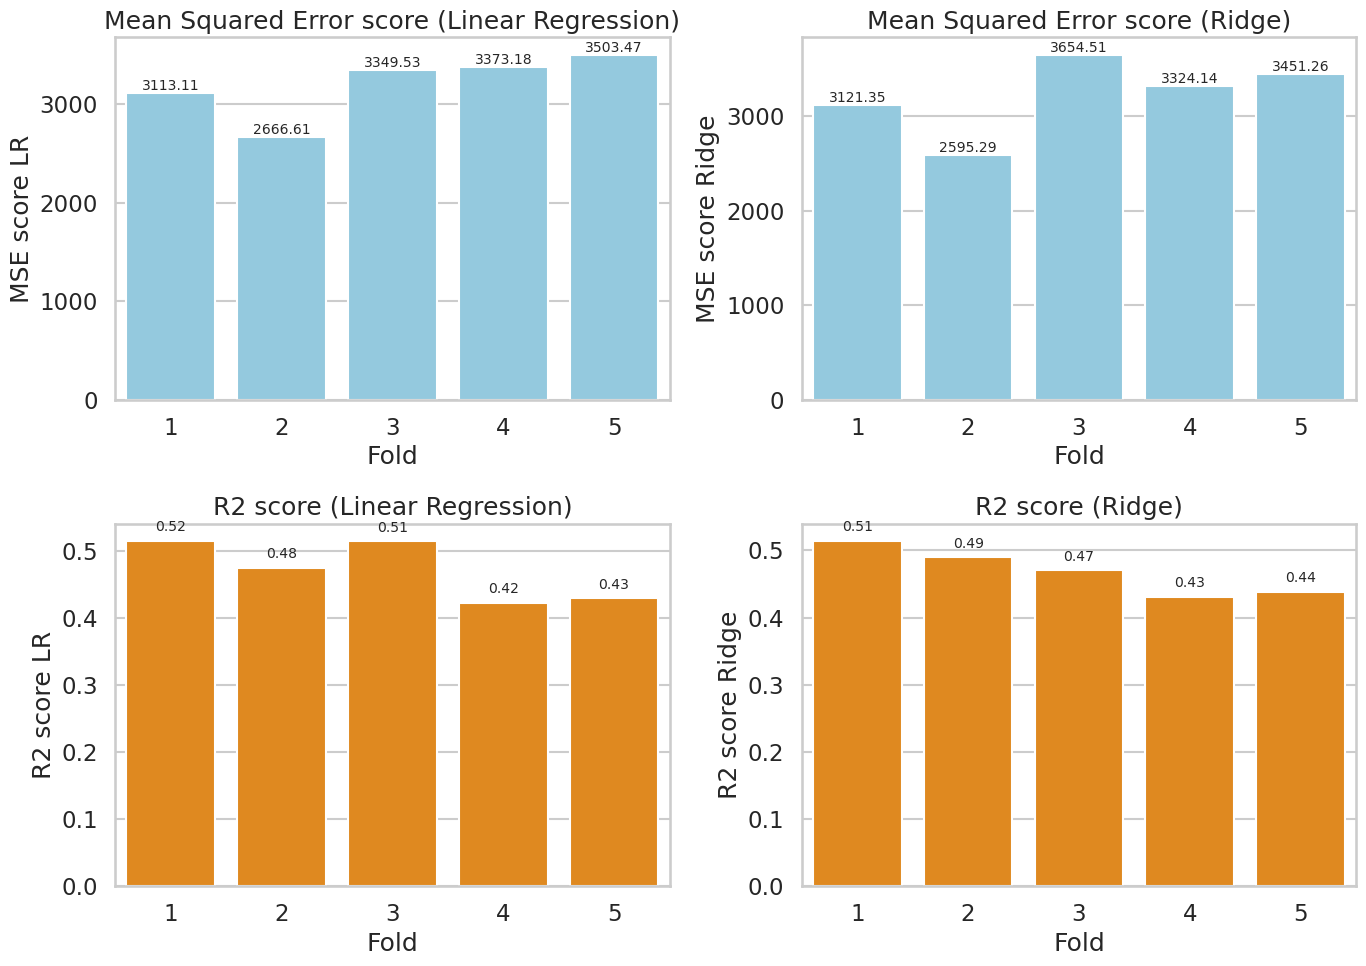

In [6]:
figure, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (score_value, score_name) in zip(
                                            axes,
                                            zip([mse_scores, mse_scores_ridge, r2_scores, r2_scores_ridge],
                                                ['MSE score LR', 'MSE score Ridge', 'R2 score LR', 'R2 score Ridge'])
                                        ):
    color = 'skyblue' if 'MSE' in score_name else 'darkorange'

    sns.barplot(y=score_value, x=list(range(1, n_splits + 1)), ax=ax, color=color)
    
    for i, score in enumerate(score_value):
        ax.text(i, score + 0.01, f"{score:.2f}", ha='center', va='bottom', fontsize=10)
    
    ax.set_ylabel(f'{score_name}')
    ax.set_xlabel('Fold')

    title = score_name.replace('MSE', 'Mean Squared Error')
    title = title.replace('LR', '(Linear Regression)')
    title = title.replace('Ridge', '(Ridge)')
    ax.set_title(title)

figure.tight_layout()

---
---
---

In [7]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.pipeline import make_pipeline

data = fetch_california_housing()

features_housing = data.data
target_housing = data.target

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features_housing, target_housing, test_size=0.3, shuffle=True, random_state=42)

rkfold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# r2_scores_housing = []
# rmse_scores_housing = []

# for training_index, validation_index in rkfold.split(X_train_2, y_train_2):
#     training_features   = X_train_2[training_index]
#     training_target     = y_train_2[training_index]
#     validation_features = X_train_2[validation_index]
#     validation_target   = y_train_2[validation_index]

#     # model = CustomLinearRegression(learning_rate=0.1, regularize=True, regularization_strength=2, tolerance=1e-3)
#     # model = Ridge(alpha=0.1)
#     model = make_pipeline(StandardScaler(), Ridge(alpha=0.1))
#     model.fit(training_features, training_target)

#     predictions = model.predict(validation_features)

#     r2 = r2_score(validation_target, predictions)
#     rmse = np.sqrt(mean_squared_error(validation_target, predictions))

#     r2_scores_housing.append(np.round(r2, 3))
#     rmse_scores_housing.append(np.round(rmse, 2))


def run_cv(model, X, y, cv, metrics=("r2", "rmse"), return_preds=False):
    """Run cross-validation with full control, returning scores and optional predictions."""

    results = []
    all_preds = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)

        fold_result = {"Fold": fold_idx}
        if "r2" in metrics:
            fold_result["R2"] = r2_score(y_val, preds)
        if "rmse" in metrics:
            fold_result["RMSE"] = np.sqrt(mean_squared_error(y_val, preds))

        results.append(fold_result)

        if return_preds:
            all_preds.append(pd.DataFrame({
                "Fold": fold_idx,
                "y_true": y_val,
                "y_pred": preds
            }))
    
    results_df = pd.DataFrame(results)
    preds_df = pd.concat(all_preds) if return_preds else None
    
    return results_df, preds_df

ridge_model = make_pipeline(StandardScaler(), Ridge(alpha=0.1))

cv_results, predictions_df = run_cv(ridge_model, X_train_2, y_train_2, cv=rkfold, metrics=('r2', 'rmse'), return_preds=True)

print(cv_results)
print("Mean R²:", cv_results["R2"].mean(), "±", cv_results["R2"].std())
print("Mean RMSE:", cv_results["RMSE"].mean(), "±", cv_results["RMSE"].std())

    Fold        R2      RMSE
0      1  0.611279  0.731459
1      2  0.581907  0.740796
2      3  0.586468  0.728985
3      4  0.632557  0.714942
4      5  0.624951  0.706956
5      6  0.604611  0.733006
6      7  0.607470  0.708882
7      8  0.609493  0.714005
8      9  0.606570  0.730914
9     10  0.604645  0.742397
10    11  0.624307  0.716038
11    12  0.620421  0.710625
12    13  0.595561  0.738901
13    14  0.592220  0.734970
14    15  0.610157  0.719374
Mean R²: 0.6075078022758962 ± 0.0143871213222533
Mean RMSE: 0.7248167264139292 ± 0.012325928224933986


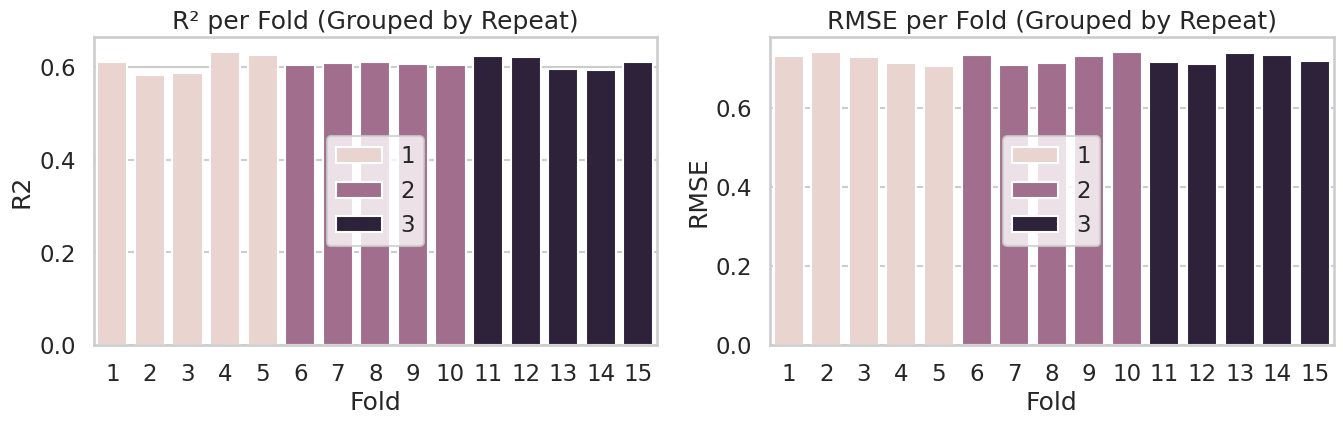

In [8]:
n_splits = 5
n_repeats = len(cv_results) // n_splits

cv_results["Repeat"] = np.repeat(range(1, n_repeats + 1), n_splits)
cv_results["Fold_in_Repeat"] = list(range(1, n_splits + 1)) * n_repeats

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

sns.barplot(x='Fold', y='R2', data=cv_results,  ax=axes[0], hue='Repeat')
axes[0].set_title("R² per Fold (Grouped by Repeat)")
axes[0].legend(loc='center')

sns.barplot(x='Fold', y='RMSE', data=cv_results,  ax=axes[1], hue='Repeat')
axes[1].set_title("RMSE per Fold (Grouped by Repeat)")
axes[1].legend(loc='center');

In [9]:
model = make_pipeline(StandardScaler(), Ridge(alpha=0.1))

r2_cross_val_score = cross_val_score(model, X_train_2, y_train_2, scoring='r2', cv=rkfold)
print("R² mean ± std:", np.mean(r2_cross_val_score), "±", np.std(r2_cross_val_score))

neg_mse_scores = cross_val_score(model, X_train_2, y_train_2, scoring='neg_mean_squared_error', cv=rkfold)
rmse_cross_val_score = np.sqrt(abs(neg_mse_scores))
print("RMSE mean ± std:", np.mean(rmse_cross_val_score), "±", np.std(rmse_cross_val_score))

R² mean ± std: 0.6075078022758962 ± 0.013899279691593847
RMSE mean ± std: 0.7248167264139292 ± 0.011907977976933895
